In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import accuracy_score, classification_report

2025-09-01 01:22:50.153857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756689770.318361      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756689770.371823      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = "/kaggle/input/coffee-bean-tanvir/train"
test_dir = "/kaggle/input/coffee-bean-tanvir/test"

# Training Data Generator (with validation split)
# ======================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   # 20% of training data for validation
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'    # <-- this is the training subset
)

# Validation generator
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # <-- this is the validation subset
)


# Test Data Generator (final evaluation)
# ======================
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Quick sanity check
# ======================
print("Train classes mapping:", train_gen.class_indices)
print("Validation classes mapping:", val_gen.class_indices)
print("Test classes mapping:", test_gen.class_indices)

Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Train classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Validation classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Test classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}


In [4]:
# Self-Attention Block (lightweight)
# ======================
def self_attention_block(x, num_heads=4, key_dim=32, ff_dim=128):
    """
    Transformer-style Self-Attention Block:
    MHSA + FFN (with residuals and LayerNorm)
    """
    h, w, c = x.shape[1], x.shape[2], x.shape[3]
    reshaped = layers.Reshape((-1, c))(x)   # (batch, H*W, C)

    # Multi-Head Self-Attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(reshaped, reshaped)
    attn_output = layers.Add()([reshaped, attn_output])
    attn_output = layers.LayerNormalization()(attn_output)

    # Feed Forward Network (2-layer MLP)
    ffn = layers.Dense(ff_dim, activation='relu')(attn_output)
    ffn = layers.Dense(c)(ffn)   # project back to channel dim
    ffn_output = layers.Add()([attn_output, ffn])
    ffn_output = layers.LayerNormalization()(ffn_output)

    # Reshape back
    out = layers.Reshape((h, w, c))(ffn_output)
    return out

In [5]:
# Build Self-Attention CNN
# ======================
def build_sa_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Conv Block 1 (no attention yet)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    # Conv Block 2 (add attention+FFN at 32×32)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = self_attention_block(x, num_heads=4, key_dim=32, ff_dim=128)

    # Conv Block 3 (add attention+FFN at 16×16)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = self_attention_block(x, num_heads=4, key_dim=32, ff_dim=256)

    # Global Average Pooling
    gap = layers.GlobalAveragePooling2D()(x)

    # Dense Head
    dense = layers.Dense(256, activation='relu')(gap)
    dense = layers.Dropout(0.5)(dense)
    outputs = layers.Dense(num_classes, activation='softmax')(dense)

    model = models.Model(inputs, outputs)
    return model

In [6]:
# Compile & Train
# ======================
num_classes = train_gen.num_classes
sa_model = build_sa_cnn(input_shape=(128,128,3), num_classes=num_classes)

sa_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = sa_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1
)

I0000 00:00:1756689783.344599      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756689794.929632     115 service.cc:148] XLA service 0x7aaec0003960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756689794.930255     115 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756689795.941306     115 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/30 ━━━━━━━━━━━━━━━━━━━━ 8:11 17s/step - accuracy: 0.4062 - loss: 1.7009

I0000 00:00:1756689802.310426     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 514ms/step - accuracy: 0.2831 - loss: 1.6410 - val_accuracy: 0.3958 - val_loss: 1.3642
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 270ms/step - accuracy: 0.3623 - loss: 1.3284 - val_accuracy: 0.4458 - val_loss: 1.2334
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.5503 - loss: 0.9117 - val_accuracy: 0.5667 - val_loss: 0.7701
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - accuracy: 0.6704 - loss: 0.6988 - val_accuracy: 0.6583 - val_loss: 0.7088
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.7660 - loss: 0.5548 - val_accuracy: 0.8167 - val_loss: 0.4886
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.8325 - loss: 0.4636 - val_accuracy: 0.9708 - val_loss: 0.1437
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.9360 - loss: 0.1716 - val_accuracy: 0.9750 - val_loss: 0.1078
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.9457 - loss: 0.1429 - val_accuracy: 0.9208 - val

In [7]:
# Feature Extraction (GlobalAveragePooling2D output)
# ======================
feature_extractor = models.Model(
    inputs=sa_model.input,
    outputs=sa_model.layers[-4].output   # GAP output before Dense
)

def extract_features(model, generator):
    features = []
    labels = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        feat = model.predict(x_batch, verbose=0)
        features.append(feat)
        labels.append(np.argmax(y_batch, axis=1))
    features = np.vstack(features)
    labels = np.hstack(labels)
    return features, labels

X_train, y_train = extract_features(feature_extractor, train_gen)
X_val, y_val     = extract_features(feature_extractor, val_gen)
X_test, y_test   = extract_features(feature_extractor, test_gen)

In [8]:
# Scale features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Train KNN Classifier
knn_clf = KNeighborsClassifier(n_neighbors=5) # You can adjust n_neighbors
knn_clf.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [10]:
# ---- Training ----
start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=5)  # Adjust n_neighbors if needed
knn.fit(X_train_scaled, y_train)
train_time = time.time() - start_time
print(f"Training Time: {train_time:.4f} seconds")

# ---- Validation ----
start_time = time.time()
y_val_pred = knn.predict(X_val_scaled)
val_time = time.time() - start_time
print(f"Validation Prediction Time: {val_time:.4f} seconds")
print("Validation Accuracy (KNN):", accuracy_score(y_val, y_val_pred))

# ---- Testing ----
start_time = time.time()
y_test_pred = knn.predict(X_test_scaled)
test_time = time.time() - start_time
print(f"Test Prediction Time: {test_time:.4f} seconds")
print("Test Accuracy (KNN):", accuracy_score(y_test, y_test_pred))

# ---- Classification Report ----
print(classification_report(y_test, y_test_pred, target_names=list(train_gen.class_indices.keys())))

Training Time: 0.0008 seconds
Validation Prediction Time: 0.0510 seconds
Validation Accuracy (KNN): 0.9916666666666667
Test Prediction Time: 0.0222 seconds
Test Accuracy (KNN): 0.9775
              precision    recall  f1-score   support

        Dark       0.98      0.97      0.97       100
       Green       1.00      1.00      1.00       100
       Light       1.00      0.96      0.98       100
      Medium       0.93      0.98      0.96       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



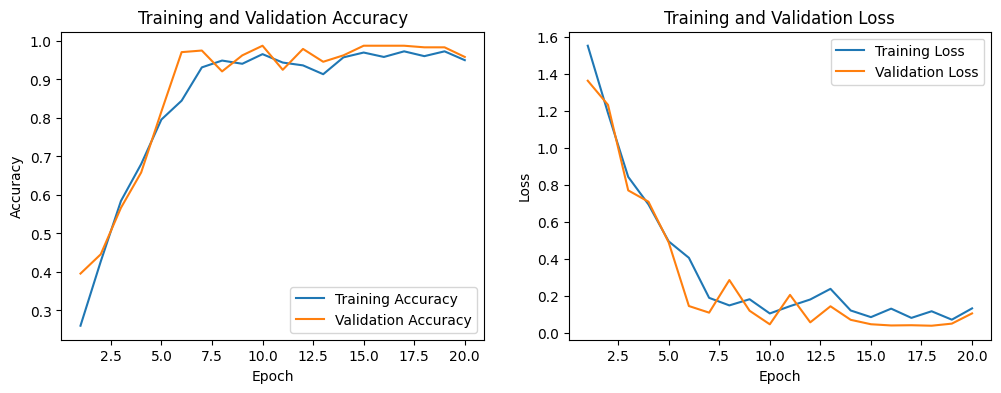

In [11]:
# Training Curves (Accuracy & Loss)
# ======================
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)

plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

Accuracy: 0.9775
Precision (macro): 0.9782828282828282
Recall (macro): 0.9774999999999999
F1-score (macro): 0.9776409423924
Confusion Matrix:
 [[ 97   0   0   3]
 [  0 100   0   0]
 [  0   0  96   4]
 [  2   0   0  98]]

Classification Report:
               precision    recall  f1-score   support

        Dark       0.98      0.97      0.97       100
       Green       1.00      1.00      1.00       100
       Light       1.00      0.96      0.98       100
      Medium       0.93      0.98      0.96       100

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



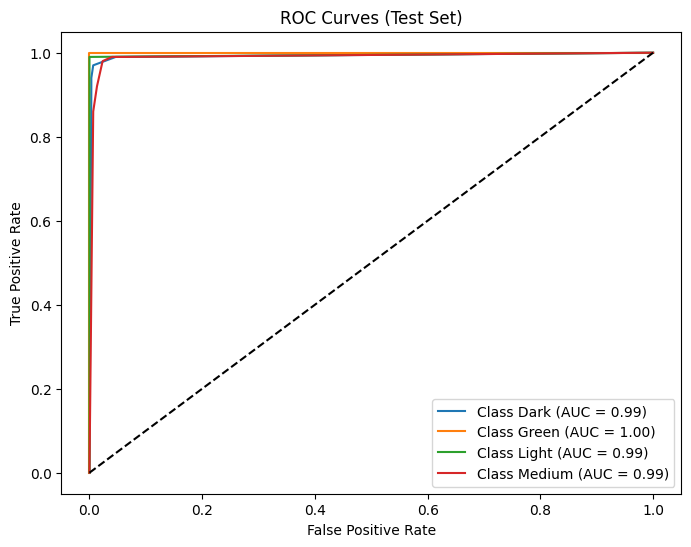

Overall Test AUC: 0.994325


In [12]:
# ---- Predictions ----
y_test_pred = knn_clf.predict(X_test_scaled)
y_test_proba = knn_clf.predict_proba(X_test_scaled)

# ---- Basic Metrics ----
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision (macro):", precision_score(y_test, y_test_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_test_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_test_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=list(test_gen.class_indices.keys())))

# ---- ROC-AUC Curves ----
classes_present = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes_present)

if y_test_bin.shape[1] > 1:  # only if >1 class
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {list(test_gen.class_indices.keys())[i]} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend()
    plt.show()

    print("Overall Test AUC:", roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'))
else:
    print("ROC-AUC skipped: less than 2 classes present in test set")